# RATIO 2019 - Benchmarking Workshop

https://gluon-nlp.mxnet.io/install.html

```
pip install --upgrade 'mxnet>=1.3.0'
pip install gluonnlp
wget https://gluon-nlp.mxnet.io/_downloads/sentence_embedding.zip
unzip sentence_embedding.zip
ln -s sentence_embedding/bert bert
```

In [1]:
import datetime
import logging
import os
import random
import time
import warnings

import gluonnlp as nlp
import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
import pandas as pd
import seaborn as sns

from bert import *
from mxnet import gluon
from mxnet.gluon.data import SimpleDataset
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score)
from sklearn.model_selection import train_test_split
from sklearn import utils
from tqdm import tqdm

In [2]:
warnings.filterwarnings('ignore')

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO)

In [3]:
# set repeatable random state
np.random.seed(100)
random.seed(100)
mx.random.seed(10000)

In [4]:
# apply progress bars for pandas .apply() -> .progress_apply()
tqdm.pandas()

In [5]:
class Timer:
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.time_start = time.time()

    def __exit__(self, *exc):
        time_end = time.time()
        time_delta = datetime.timedelta(seconds=(time_end - self.time_start))
        if self.name:
            print(("Time for [{}]: {}".format(self.name, time_delta)))
        else:
            print(("Time: {}".format(time_delta)))

# Task 1 - Same Side Classification

In [6]:
data_cross_path = 'data/same-side-classification/cross-topic/{}.csv'
data_within_path = 'data/same-side-classification/within-topic/{}.csv'

In [ ]:
%%bash
head -n 5 data/same-side-classification/cross-topic/training.csv

### Load within-topics and cross-topics data

In [7]:
# escapechar to detect quoting escapes, else it fails

# na_filter=False, because pandas automatic "nan" detection fails with the topic column, too
# cross_test_df['topic'].astype(str)[9270]

# within has "is_same_side" as string
# cross has "is_same_side" as boolean (auto cast?)

with Timer("read cross"):
    cross_traindev_df = pd.read_csv(data_cross_path.format('training'), index_col='id', escapechar='\\', na_filter=False)
    cross_test_df = pd.read_csv(data_cross_path.format('test'), index_col='id', escapechar='\\', na_filter=False)

with Timer("read within"):
    within_traindev_df = pd.read_csv(data_within_path.format('training'), index_col='id', escapechar='\\', na_filter=False)
    within_test_df = pd.read_csv(data_within_path.format('test'), index_col='id', escapechar='\\', na_filter=False)

Time for [read cross]: 0:00:00.880218
Time for [read within]: 0:00:00.948990


In [8]:
# Adding a tag for the topics in focus: "gay marriage" and "abortion"
def add_tag(row):
    title = row['topic'].lower().strip()
    if "abortion" in title:
        row['tag'] = 'abortion'
    elif "gay marriage"  in title:
        row['tag'] = 'gay marriage'
    else:
        row['tag'] = 'NA'
    return row


with Timer("tag cross traindev"):
    cross_traindev_df = cross_traindev_df.apply(add_tag, axis=1)
with Timer("tag cross test"):
    cross_test_df = cross_test_df.apply(add_tag, axis=1)

with Timer("tag within traindev"):
    within_traindev_df = within_traindev_df.apply(add_tag, axis=1)
with Timer("tag within test"):
    within_test_df = within_test_df.apply(add_tag, axis=1)

Time for [tag cross traindev]: 0:00:31.274064
Time for [tag cross test]: 0:00:17.586342
Time for [tag within traindev]: 0:00:32.984221
Time for [tag within test]: 0:00:16.179674


### Get an overview about each dataset

In [9]:
# requires nltk  wordtokenize
# from nltk.tokenize import sent_tokenize, word_tokenize
# model uses BERT Tokenizer ...

def get_overview(df, task='same-side', class_name='is_same_side'):
    # Total instance numbers
    total = len(df)
    print("Task: ", task)
    print('=' * 40, '\n')

    print('Total instances: ', total)
    print('\n')

    print('For each topic:')
    for tag, tag_df in df.groupby(['tag']):
        print(tag, ': ', len(tag_df), ' instances')
        if class_name in df.columns:
            for is_same_side, side_df in tag_df.groupby([class_name]):
                print('\t\t', is_same_side, ': ', len(side_df), ' instances')
    print('\n')

    if class_name in df.columns:
        print('For each class value:')
        for class_value, class_df in df.groupby([class_name]):
            print(class_value, ': ', len(class_df), ' instances')
        print('\n')

    print('Unique argument1:', len(df['argument1'].unique()))
    print('Unique argument2:', len(df['argument2'].unique()))
    arguments = df['argument1'].values
    arguments = np.concatenate([arguments, df['argument2'].values])

    print('Unique total arguments:', len(set(list(arguments))), '\n')

    print('-' * 40, '\n')

    arguments_length_lst = [
        len(word_tokenize(x)) for x in df['argument1'].values
    ]
    arguments_length_lst.extend(
        [len(word_tokenize(x)) for x in df['argument2'].values])
    print('Words:')
    print('\tshortest argument:', min(arguments_length_lst), ' words')
    print('\tlongest argument:', max(arguments_length_lst), ' words')
    print('\targument average length:', np.mean(arguments_length_lst),
          ' words')

    arguments_sent_length_lst = [
        len(sent_tokenize(x)) for x in df['argument1'].values
    ]
    arguments_sent_length_lst.extend(
        [len(sent_tokenize(x)) for x in df['argument2'].values])
    print('Sentences:')
    print('\tshortest argument:', min(arguments_sent_length_lst), ' sentences')
    print('\tlongest argument:', max(arguments_sent_length_lst), ' sentences')
    print('\targument average length:', np.mean(arguments_sent_length_lst),
          ' sentences')

In [ ]:
# with Timer("overview cross"):
#     get_overview(cross_traindev_df)

In [ ]:
# with Timer("overview within"):
#     get_overview(within_traindev_df)

## Train model - Baseline

### train dev set - 70% 30%

In [10]:
def get_train_test_sets(df, ratio=0.30, random_state=1):
    X = df[['argument1', 'argument2', 'argument1_id', 'argument2_id', 'topic']]
    y = df[['is_same_side']]

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=ratio,
                                                        random_state=random_state,
                                                        shuffle=True)
    return X_train, X_test, y_train, y_test

### BERT

- https://gluon-nlp.mxnet.io/examples/sentence_embedding/bert.html

In [39]:
class MyBERTDataset(SimpleDataset):
    def __init__(self, X, y=None):
        self._X = X
        self._y = y
        super(MyBERTDataset, self).__init__(self._convert())
    
    def _convert(self):
        allsamples = list()

        if self._y is not None:
            df = self._X.merge(self._y, left_index=True, right_index=True)
            for _, row in df.iterrows():
                allsamples.append([row['argument1'], row['argument2'], "1" if str(row['is_same_side']) == "True" else "0"])
        else:
            for _, row in self._X.iterrows():
                allsamples.append([row['argument1'], row['argument2'], None])
        
        return allsamples

    # for lazy retrieval?
    #
    # def __getitem__(self, idx):
    #     row_X = self._X.iloc[idx]
    #     row_y = self._y.iloc[idx]
    #     return [row_X['argument1'], row_X['argument2'], "1" if row_y['is_same_side'] else "0"]
    #
    # def __len__(self):
    #     return len(self._X)

In [ ]:
# df = X_dev.merge(y_dev, left_index=True, right_index=True)
# allsamples = list()
# for _, row in df.iterrows():
#     allsamples.append("1" if row['is_same_side'] == "True" else "0")
# np.unique(allsamples)

In [12]:
def setup_bert():
    # change `ctx` to `mx.cpu()` if no GPU is available.
    ctx = mx.gpu(0)
    # ctx =  mx.gpu() if mx.context.num_gpus() else mx.cpu()
    # ctx = mx.cpu()
    
    bert_base, vocabulary = nlp.model.get_model('bert_12_768_12',
                                                 dataset_name='book_corpus_wiki_en_uncased',
                                                 pretrained=True, ctx=ctx, use_pooler=True,
                                                 use_decoder=False, use_classifier=False)
    print(bert_base)
    
    model = bert.BERTClassifier(bert_base, num_classes=2, dropout=0.1)
    # only need to initialize the classifier layer.
    model.classifier.initialize(init=mx.init.Normal(0.02), ctx=ctx)
    model.hybridize(static_alloc=True)

    # softmax cross entropy loss for classification
    loss_function = gluon.loss.SoftmaxCELoss()
    loss_function.hybridize(static_alloc=True)

    metric = mx.metric.Accuracy()
    
    # use the vocabulary from pre-trained model for tokenization
    bert_tokenizer = nlp.data.BERTTokenizer(vocabulary, lower=True)
    # maximum sequence length
    max_len = 128
    # the labels for the two classes
    all_labels = ["0", "1"]
    # whether to transform the data as sentence pairs.
    # for single sentence classification, set pair=False
    pair = True
    transform = dataset.BERTDatasetTransform(bert_tokenizer, max_len,
                                             labels=all_labels,
                                             label_dtype='int32',
                                             pad=True,
                                             pair=pair)

    return model, vocabulary, ctx, transform, loss_function, metric, all_labels

In [43]:
def transform_dataset(X, y, transform):
    data_train_raw = MyBERTDataset(X, y)
    data_train = data_train_raw.transform(transform)
    return data_train_raw, data_train


def predict_out_to_ys(all_predictions, all_labels):
    y_true, y_pred = list(), list()
    
    for _, y_true_many, y_pred_many in all_predictions:
        y_true_many = y_true_many.T[0].asnumpy()
        # https://mxnet.incubator.apache.org/api/python/gluon/loss.html#mxnet.gluon.loss.SoftmaxCrossEntropyLoss
        # pred: the prediction tensor, where the batch_axis dimension ranges over batch size and axis dimension ranges over the number of classes.
        y_pred_many = np.argmax(y_pred_many, axis=1).asnumpy()

        y_true.extend(list(y_true_many))
        y_pred.extend(list(y_pred_many))
        # TODO: convert label_id to label?
        # y_pred.extend(all_labels[c] for c in list(y_pred_many))
        
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    return y_true, y_pred

In [14]:
def train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=3):
    with Timer("setup training"):
        train_sampler = nlp.data.FixedBucketSampler(
            lengths=[int(item[1]) for item in tqdm(data_train)],
            batch_size=batch_size,
            shuffle=True)
        bert_dataloader = mx.gluon.data.DataLoader(data_train,
                                                   batch_sampler=train_sampler)

        trainer = gluon.Trainer(model.collect_params(), 'adam', {
            'learning_rate': lr,
            'epsilon': 1e-9
        })

        # collect all differentiable parameters
        # grad_req == 'null' indicates no gradients are calculated (e.g. constant parameters)
        # the gradients for these params are clipped later
        params = [p for p in model.collect_params().values() if p.grad_req != 'null']

    log_interval = 10
    with Timer("training"):
        stats = list()
        for epoch_id in range(num_epochs):
            epoch_checkpoint_savefile = "data/bert.model.checkpoint{}.params".format(epoch_id)
            if os.path.exists(epoch_checkpoint_savefile):
                model.load_parameters(epoch_checkpoint_savefile, ctx=ctx)
                print("loaded checkpoint for epoch {}".format(epoch_id))
                continue

            with Timer("epoch {}".format(epoch_id)):
                metric.reset()
                step_loss = 0
                t_p = time.time()  # time keeping
                for batch_id, (token_ids, valid_length, segment_ids,
                               label) in enumerate(bert_dataloader):
                    with mx.autograd.record():

                        # load data to GPU
                        token_ids = token_ids.as_in_context(ctx)
                        valid_length = valid_length.as_in_context(ctx)
                        segment_ids = segment_ids.as_in_context(ctx)
                        label = label.as_in_context(ctx)

                        # forward computation
                        out = model(token_ids, segment_ids,
                                    valid_length.astype('float32'))
                        ls = loss_function(out, label).mean()

                    # backward computation
                    ls.backward()

                    # gradient clipping
                    trainer.allreduce_grads()
                    nlp.utils.clip_grad_global_norm(params, 1)
                    trainer.update(1)

                    step_loss += ls.asscalar()
                    metric.update([label], [out])
                    stats.append((metric.get()[1], ls.asscalar()))
                    if (batch_id + 1) % (log_interval) == 0:
                        print(
                            '[Epoch {} Batch {}/{}] loss={:.4f}, lr={:.7f}, acc={:.3f} - time {}'
                            .format(epoch_id, batch_id + 1, len(bert_dataloader),
                                    step_loss / log_interval, trainer.learning_rate,
                                    metric.get()[1],
                                    datetime.timedelta(seconds=(time.time() - t_p))))
                        t_p = time.time()
                        step_loss = 0

            model.save_parameters(epoch_checkpoint_savefile)
            
    return stats

In [47]:
def predict(model, data_predict, ctx, metric, loss_function, batch_size=32):
    bert_dataloader = mx.gluon.data.DataLoader(data_predict, batch_size=batch_size)
    
    all_predictions = list()

    with Timer("prediction"):
        metric.reset()
        cum_loss = 0
        for batch_id, (token_ids, valid_length, segment_ids,
                       label) in enumerate(tqdm(bert_dataloader)):
            # load data to GPU
            token_ids = token_ids.as_in_context(ctx)
            valid_length = valid_length.as_in_context(ctx)
            segment_ids = segment_ids.as_in_context(ctx)
            label = label.as_in_context(ctx)

            # forward computation
            out = model(token_ids, segment_ids,
                        valid_length.astype('float32'))
            ls = loss_function(out, label).mean()

            metric.update([label], [out])
            cum_loss += ls.asscalar()  # .sum() ?
            all_predictions.append((batch_id, label, out))
            
    return all_predictions, cum_loss

In [16]:
def print_infos(vocabulary, data_train_raw, data_train):
    sample_id = 0

    # sentence a
    print(data_train_raw[sample_id][0])
    # sentence b
    print(data_train_raw[sample_id][1])
    # 1 means equivalent, 0 means not equivalent
    print(data_train_raw[sample_id][2])

    print('vocabulary used for tokenization = \n%s'%vocabulary)
    print('[PAD] token id = %s'%(vocabulary['[PAD]']))
    print('[CLS] token id = %s'%(vocabulary['[CLS]']))
    print('[SEP] token id = %s'%(vocabulary['[SEP]']))

    print('token ids = \n%s'%data_train[sample_id][0])
    print('valid length = \n%s'%data_train[sample_id][1])
    print('segment ids = \n%s'%data_train[sample_id][2])
    print('label = \n%s'%data_train[sample_id][3])
    

def plot_train_stats(stats):
    if not stats:
        print("no stats to plot")
        return

    x = np.arange(len(stats))  # arange/linspace

    acc_dots, loss_dots = zip(*stats)

    plt.subplot(2, 1, 1)
    plt.plot(x, acc_dots)  # Linie: '-', 'o-', '.-'
    plt.title('Training BERTClassifier')
    plt.ylabel('Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(x, loss_dots)
    plt.xlabel('Batches')
    plt.ylabel('Loss')

    plt.show()

### Evaluate

In [17]:
def heatconmat(y_test, y_pred):
    sns.set_context('talk')
    plt.figure(figsize=(9, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='gist_earth_r',
                yticklabels=sorted(np.unique(y_test)))
    plt.show()


def report_training_results(y_test, y_pred, name=None, heatmap=True):
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    if heatmap:
        heatconmat(y_test, y_pred)
    print()
    print('Accuracy: ', round(accuracy_score(y_test, y_pred), 2), '\n')  #

    print('Report{}:'.format("" if not name else " for [{}]".format(name)))
    print(classification_report(y_test, y_pred))

    f1_dic = {}
    f1_dic['macro'] = round(
        f1_score(y_pred=y_pred, y_true=y_test, average='macro'), 2)
    f1_dic['micro'] = round(
        f1_score(y_pred=y_pred, y_true=y_test, average='micro'), 2)
    return f1_dic

### Within topic - Training and evaluating model 

In [18]:
# 1. Getting train and dev data
with Timer("1 - test/train split"):
    X_train, X_dev, y_train, y_dev = get_train_test_sets(within_traindev_df)

Time for [1 - test/train split]: 0:00:00.027842


In [19]:
# 2. setup
with Timer("2 - setup BERT model"):
    model, vocabulary, ctx, transform, loss_function, metric, all_labels = setup_bert()

BERTModel(
  (encoder): BERTEncoder(
    (dropout_layer): Dropout(p = 0.1, axes=())
    (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
    (transformer_cells): HybridSequential(
      (0): BERTEncoderCell(
        (dropout_layer): Dropout(p = 0.1, axes=())
        (attention_cell): MultiHeadAttentionCell(
          (_base_cell): DotProductAttentionCell(
            (_dropout_layer): Dropout(p = 0.1, axes=())
          )
          (proj_query): Dense(768 -> 768, linear)
          (proj_key): Dense(768 -> 768, linear)
          (proj_value): Dense(768 -> 768, linear)
        )
        (proj): Dense(768 -> 768, linear)
        (ffn): BERTPositionwiseFFN(
          (ffn_1): Dense(768 -> 3072, linear)
          (activation): GELU()
          (ffn_2): Dense(3072 -> 768, linear)
          (dropout_layer): Dropout(p = 0.1, axes=())
          (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
        )
        (la

In [20]:
with Timer("3 - prepare training data"):
    data_train_raw, data_train = transform_dataset(X_train, y_train, transform)
    print_infos(vocabulary, data_train_raw, data_train)

wanted fetuses are beloved "babies"; unwanted ones are "tissue" (inconsistent)
abortions are emotionally and psychologically unsafe.
1
vocabulary used for tokenization = 
Vocab(size=30522, unk="[UNK]", reserved="['[PAD]', '[CLS]', '[SEP]', '[MASK]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = 
[    2  2359 10768  5809  2229  2024 11419  1000 10834  1000  1025 18162
  3924  2024  1000  8153  1000  1006 20316  1007     3 11324  2015  2024
 14868  1998  8317  2135 25135  1012     3     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1   

In [ ]:
with Timer("4 - train model"):
    # train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=3)
    stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=2)
    # model.save_parameters("data/same-side-classification/within-topic/bert.model.params")
    model.save_parameters("data/bert.model.params")

    plot_train_stats(stats)

In [21]:
with Timer("5 - prepare eval data"):
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    print_infos(vocabulary, data_dev_raw, data_dev)

abortion opens the door to the sexual exploitation of women the existence of abortion gives men a little more of a safeguard against unintentionally impregnating a woman. as a result, men will be more aggressive in their sexual exploitation of women.
the fact that a child is likely to have a short life does not justify further shortening it:
0
vocabulary used for tokenization = 
Vocab(size=30522, unk="[UNK]", reserved="['[PAD]', '[CLS]', '[SEP]', '[MASK]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = 
[    2 11324  7480  1996  2341  2000  1996  4424 14427  1997  2308  1996
  4598  1997 11324  3957  2273  1037  2210  2062  1997  1037 28805  2114
  4895 18447  4765 19301  2135 17727  2890 16989  3436  1037  2450  1012
  2004  1037  2765  1010  2273  2097  2022  2062  9376  1999  2037  4424
 14427  1997  2308  1012     3  1996  2755  2008  1037  2775  2003  3497
  2000  2031  1037  2460  2166  2515  2025 16114  2582  2460  7406  2009
  1024     3     1     1     

In [ ]:
with Timer("6 - evaluate"):
    # model.load_parameters("data/same-side-classification/within-topic/bert.model.params", ctx=ctx)
    model.load_parameters("data/bert.model.params", ctx=ctx)
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name="BERTClassifier", heatmap=False)

### Train and evaluate each epoch

100%|██████████| 44732/44732 [03:03<00:00, 243.64it/s]


Time for [setup training]: 0:03:03.616516
[Epoch 0 Batch 10/1401] loss=0.7123, lr=0.0000050, acc=0.463 - time 0:00:08.398131
[Epoch 0 Batch 20/1401] loss=0.7044, lr=0.0000050, acc=0.472 - time 0:00:07.934280
[Epoch 0 Batch 30/1401] loss=0.6946, lr=0.0000050, acc=0.492 - time 0:00:07.604617
[Epoch 0 Batch 40/1401] loss=0.7027, lr=0.0000050, acc=0.491 - time 0:00:07.670415
[Epoch 0 Batch 50/1401] loss=0.7174, lr=0.0000050, acc=0.485 - time 0:00:08.080510
[Epoch 0 Batch 60/1401] loss=0.7049, lr=0.0000050, acc=0.486 - time 0:00:07.846084
[Epoch 0 Batch 70/1401] loss=0.6898, lr=0.0000050, acc=0.489 - time 0:00:07.760846
[Epoch 0 Batch 80/1401] loss=0.6801, lr=0.0000050, acc=0.498 - time 0:00:08.219248
[Epoch 0 Batch 90/1401] loss=0.6777, lr=0.0000050, acc=0.507 - time 0:00:07.421381
[Epoch 0 Batch 100/1401] loss=0.6774, lr=0.0000050, acc=0.510 - time 0:00:08.345424
[Epoch 0 Batch 110/1401] loss=0.6804, lr=0.0000050, acc=0.512 - time 0:00:08.270515
[Epoch 0 Batch 120/1401] loss=0.6767, lr=0.

[Epoch 0 Batch 990/1401] loss=0.5263, lr=0.0000050, acc=0.659 - time 0:00:07.500636
[Epoch 0 Batch 1000/1401] loss=0.4658, lr=0.0000050, acc=0.660 - time 0:00:07.690809
[Epoch 0 Batch 1010/1401] loss=0.5230, lr=0.0000050, acc=0.660 - time 0:00:07.526484
[Epoch 0 Batch 1020/1401] loss=0.4819, lr=0.0000050, acc=0.661 - time 0:00:07.744081
[Epoch 0 Batch 1030/1401] loss=0.4789, lr=0.0000050, acc=0.662 - time 0:00:08.370557
[Epoch 0 Batch 1040/1401] loss=0.4649, lr=0.0000050, acc=0.663 - time 0:00:08.505099
[Epoch 0 Batch 1050/1401] loss=0.5330, lr=0.0000050, acc=0.663 - time 0:00:07.537870
[Epoch 0 Batch 1060/1401] loss=0.5286, lr=0.0000050, acc=0.664 - time 0:00:08.045551
[Epoch 0 Batch 1070/1401] loss=0.3950, lr=0.0000050, acc=0.665 - time 0:00:08.054696
[Epoch 0 Batch 1080/1401] loss=0.4627, lr=0.0000050, acc=0.666 - time 0:00:07.645611
[Epoch 0 Batch 1090/1401] loss=0.5199, lr=0.0000050, acc=0.666 - time 0:00:08.094781
[Epoch 0 Batch 1100/1401] loss=0.4338, lr=0.0000050, acc=0.667 - t

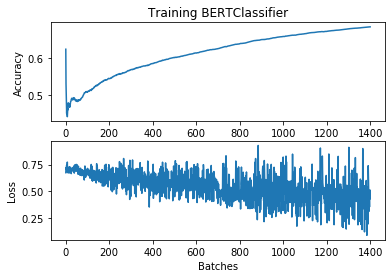

  0%|          | 0/600 [00:00<?, ?it/s]

Time for [4 - train model - 0]: 0:21:46.036421


100%|██████████| 600/600 [02:54<00:00,  3.44it/s]


Time for [prediction]: 0:02:54.673318
Accuracy in epoch 0: 0.7687131605028429
Confusion Matrix:
[[8611  222]
 [4212 6126]]

Accuracy:  0.77 

Report for [BERTClassifier]:
              precision    recall  f1-score   support

           0       0.67      0.97      0.80      8833
           1       0.97      0.59      0.73     10338

    accuracy                           0.77     19171
   macro avg       0.82      0.78      0.76     19171
weighted avg       0.83      0.77      0.76     19171

Time for [6 - evaluate - 0]: 0:02:54.909709


100%|██████████| 44732/44732 [03:03<00:00, 243.78it/s]


Time for [setup training]: 0:03:03.511105
loaded checkpoint for epoch 0
[Epoch 1 Batch 10/1401] loss=0.4424, lr=0.0000050, acc=0.734 - time 0:00:08.159002
[Epoch 1 Batch 20/1401] loss=0.4210, lr=0.0000050, acc=0.780 - time 0:00:07.750770
[Epoch 1 Batch 30/1401] loss=0.3921, lr=0.0000050, acc=0.785 - time 0:00:08.155360
[Epoch 1 Batch 40/1401] loss=0.4468, lr=0.0000050, acc=0.768 - time 0:00:07.969878
[Epoch 1 Batch 50/1401] loss=0.4592, lr=0.0000050, acc=0.766 - time 0:00:07.928524
[Epoch 1 Batch 60/1401] loss=0.4163, lr=0.0000050, acc=0.764 - time 0:00:08.215255
[Epoch 1 Batch 70/1401] loss=0.4556, lr=0.0000050, acc=0.763 - time 0:00:08.122751
[Epoch 1 Batch 80/1401] loss=0.4802, lr=0.0000050, acc=0.759 - time 0:00:08.526760
[Epoch 1 Batch 90/1401] loss=0.3910, lr=0.0000050, acc=0.762 - time 0:00:08.325558
[Epoch 1 Batch 100/1401] loss=0.4111, lr=0.0000050, acc=0.763 - time 0:00:07.941572
[Epoch 1 Batch 110/1401] loss=0.4335, lr=0.0000050, acc=0.763 - time 0:00:07.759429
[Epoch 1 Batc

[Epoch 1 Batch 980/1401] loss=0.2351, lr=0.0000050, acc=0.785 - time 0:00:07.590908
[Epoch 1 Batch 990/1401] loss=0.2772, lr=0.0000050, acc=0.785 - time 0:00:07.703087
[Epoch 1 Batch 1000/1401] loss=0.2527, lr=0.0000050, acc=0.786 - time 0:00:07.636431
[Epoch 1 Batch 1010/1401] loss=0.3386, lr=0.0000050, acc=0.786 - time 0:00:08.074847
[Epoch 1 Batch 1020/1401] loss=0.3742, lr=0.0000050, acc=0.786 - time 0:00:08.415797
[Epoch 1 Batch 1030/1401] loss=0.3482, lr=0.0000050, acc=0.786 - time 0:00:08.428457
[Epoch 1 Batch 1040/1401] loss=0.3559, lr=0.0000050, acc=0.787 - time 0:00:08.524504
[Epoch 1 Batch 1050/1401] loss=0.3071, lr=0.0000050, acc=0.787 - time 0:00:07.941499
[Epoch 1 Batch 1060/1401] loss=0.3485, lr=0.0000050, acc=0.787 - time 0:00:08.072768
[Epoch 1 Batch 1070/1401] loss=0.2816, lr=0.0000050, acc=0.788 - time 0:00:07.566499
[Epoch 1 Batch 1080/1401] loss=0.2989, lr=0.0000050, acc=0.788 - time 0:00:08.054607
[Epoch 1 Batch 1090/1401] loss=0.2885, lr=0.0000050, acc=0.788 - ti

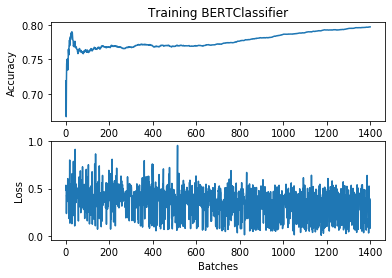

  0%|          | 0/600 [00:00<?, ?it/s]

Time for [4 - train model - 1]: 0:21:46.380248


100%|██████████| 600/600 [02:54<00:00,  3.43it/s]


Time for [prediction]: 0:02:54.965684
Accuracy in epoch 1: 0.824057169683376
Confusion Matrix:
[[8451  382]
 [2991 7347]]

Accuracy:  0.82 

Report for [BERTClassifier]:
              precision    recall  f1-score   support

           0       0.74      0.96      0.83      8833
           1       0.95      0.71      0.81     10338

    accuracy                           0.82     19171
   macro avg       0.84      0.83      0.82     19171
weighted avg       0.85      0.82      0.82     19171

Time for [6 - evaluate - 1]: 0:02:55.184790


100%|██████████| 44732/44732 [02:59<00:00, 249.02it/s]


Time for [setup training]: 0:02:59.653879
loaded checkpoint for epoch 0
loaded checkpoint for epoch 1
[Epoch 2 Batch 10/1401] loss=0.3462, lr=0.0000050, acc=0.800 - time 0:00:08.079111
[Epoch 2 Batch 20/1401] loss=0.3113, lr=0.0000050, acc=0.816 - time 0:00:08.050103
[Epoch 2 Batch 30/1401] loss=0.2746, lr=0.0000050, acc=0.813 - time 0:00:07.610560
[Epoch 2 Batch 40/1401] loss=0.2837, lr=0.0000050, acc=0.818 - time 0:00:07.937971
[Epoch 2 Batch 50/1401] loss=0.2393, lr=0.0000050, acc=0.831 - time 0:00:07.587471
[Epoch 2 Batch 60/1401] loss=0.3430, lr=0.0000050, acc=0.821 - time 0:00:08.482811
[Epoch 2 Batch 70/1401] loss=0.3721, lr=0.0000050, acc=0.813 - time 0:00:08.391128
[Epoch 2 Batch 80/1401] loss=0.2912, lr=0.0000050, acc=0.817 - time 0:00:08.059704
[Epoch 2 Batch 90/1401] loss=0.2979, lr=0.0000050, acc=0.817 - time 0:00:07.826259
[Epoch 2 Batch 100/1401] loss=0.2834, lr=0.0000050, acc=0.818 - time 0:00:07.917410
[Epoch 2 Batch 110/1401] loss=0.2697, lr=0.0000050, acc=0.821 - tim

[Epoch 2 Batch 980/1401] loss=0.3153, lr=0.0000050, acc=0.834 - time 0:00:08.360869
[Epoch 2 Batch 990/1401] loss=0.2828, lr=0.0000050, acc=0.834 - time 0:00:08.250011
[Epoch 2 Batch 1000/1401] loss=0.2661, lr=0.0000050, acc=0.834 - time 0:00:07.885297
[Epoch 2 Batch 1010/1401] loss=0.2387, lr=0.0000050, acc=0.834 - time 0:00:07.717804
[Epoch 2 Batch 1020/1401] loss=0.2589, lr=0.0000050, acc=0.835 - time 0:00:07.937639
[Epoch 2 Batch 1030/1401] loss=0.2362, lr=0.0000050, acc=0.835 - time 0:00:07.801006
[Epoch 2 Batch 1040/1401] loss=0.2740, lr=0.0000050, acc=0.835 - time 0:00:08.083806
[Epoch 2 Batch 1050/1401] loss=0.2595, lr=0.0000050, acc=0.835 - time 0:00:08.007828
[Epoch 2 Batch 1060/1401] loss=0.3250, lr=0.0000050, acc=0.835 - time 0:00:08.326101
[Epoch 2 Batch 1070/1401] loss=0.2071, lr=0.0000050, acc=0.836 - time 0:00:07.704010
[Epoch 2 Batch 1080/1401] loss=0.3205, lr=0.0000050, acc=0.835 - time 0:00:08.113818
[Epoch 2 Batch 1090/1401] loss=0.2656, lr=0.0000050, acc=0.835 - ti

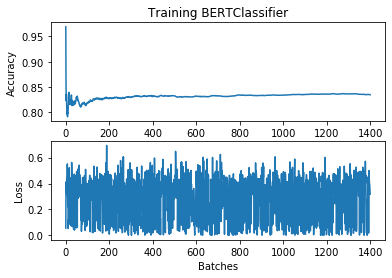

  0%|          | 0/600 [00:00<?, ?it/s]

Time for [4 - train model - 2]: 0:21:45.525216


100%|██████████| 600/600 [03:00<00:00,  3.33it/s]


Time for [prediction]: 0:03:00.302708
Accuracy in epoch 2: 0.8273955453549632
Confusion Matrix:
[[7709 1124]
 [2185 8153]]

Accuracy:  0.83 

Report for [BERTClassifier]:
              precision    recall  f1-score   support

           0       0.78      0.87      0.82      8833
           1       0.88      0.79      0.83     10338

    accuracy                           0.83     19171
   macro avg       0.83      0.83      0.83     19171
weighted avg       0.83      0.83      0.83     19171

Time for [6 - evaluate - 2]: 0:03:00.539469


100%|██████████| 44732/44732 [02:56<00:00, 253.09it/s]


Time for [setup training]: 0:02:56.764589
loaded checkpoint for epoch 0
loaded checkpoint for epoch 1
loaded checkpoint for epoch 2
[Epoch 3 Batch 10/1401] loss=0.3006, lr=0.0000050, acc=0.822 - time 0:00:08.128311
[Epoch 3 Batch 20/1401] loss=0.2490, lr=0.0000050, acc=0.833 - time 0:00:07.749291
[Epoch 3 Batch 30/1401] loss=0.2215, lr=0.0000050, acc=0.847 - time 0:00:07.787158
[Epoch 3 Batch 40/1401] loss=0.1572, lr=0.0000050, acc=0.862 - time 0:00:07.355835
[Epoch 3 Batch 50/1401] loss=0.2429, lr=0.0000050, acc=0.861 - time 0:00:07.805379
[Epoch 3 Batch 60/1401] loss=0.2901, lr=0.0000050, acc=0.858 - time 0:00:08.277955
[Epoch 3 Batch 70/1401] loss=0.2481, lr=0.0000050, acc=0.862 - time 0:00:08.124039
[Epoch 3 Batch 80/1401] loss=0.2360, lr=0.0000050, acc=0.864 - time 0:00:07.918141
[Epoch 3 Batch 90/1401] loss=0.2300, lr=0.0000050, acc=0.865 - time 0:00:07.891746
[Epoch 3 Batch 100/1401] loss=0.2626, lr=0.0000050, acc=0.864 - time 0:00:07.804849
[Epoch 3 Batch 110/1401] loss=0.3195,

[Epoch 3 Batch 980/1401] loss=0.2218, lr=0.0000050, acc=0.845 - time 0:00:07.759018
[Epoch 3 Batch 990/1401] loss=0.2551, lr=0.0000050, acc=0.845 - time 0:00:07.893662
[Epoch 3 Batch 1000/1401] loss=0.2730, lr=0.0000050, acc=0.845 - time 0:00:07.873868
[Epoch 3 Batch 1010/1401] loss=0.2823, lr=0.0000050, acc=0.845 - time 0:00:08.171168
[Epoch 3 Batch 1020/1401] loss=0.2327, lr=0.0000050, acc=0.845 - time 0:00:07.720337
[Epoch 3 Batch 1030/1401] loss=0.3336, lr=0.0000050, acc=0.845 - time 0:00:08.225332
[Epoch 3 Batch 1040/1401] loss=0.4135, lr=0.0000050, acc=0.844 - time 0:00:08.517092
[Epoch 3 Batch 1050/1401] loss=0.2479, lr=0.0000050, acc=0.844 - time 0:00:08.107582
[Epoch 3 Batch 1060/1401] loss=0.1941, lr=0.0000050, acc=0.845 - time 0:00:07.783350
[Epoch 3 Batch 1070/1401] loss=0.3166, lr=0.0000050, acc=0.845 - time 0:00:08.278350
[Epoch 3 Batch 1080/1401] loss=0.2622, lr=0.0000050, acc=0.845 - time 0:00:08.104641
[Epoch 3 Batch 1090/1401] loss=0.3534, lr=0.0000050, acc=0.844 - ti

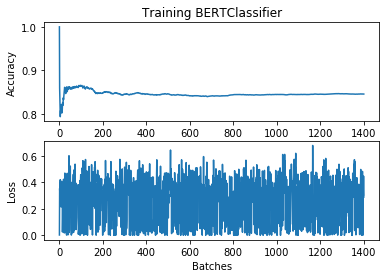

  0%|          | 0/600 [00:00<?, ?it/s]

Time for [4 - train model - 3]: 0:21:44.304399


100%|██████████| 600/600 [02:58<00:00,  3.36it/s]


Time for [prediction]: 0:02:58.403872
Accuracy in epoch 3: 0.8270304105158833
Confusion Matrix:
[[8095  738]
 [2578 7760]]

Accuracy:  0.83 

Report for [BERTClassifier]:
              precision    recall  f1-score   support

           0       0.76      0.92      0.83      8833
           1       0.91      0.75      0.82     10338

    accuracy                           0.83     19171
   macro avg       0.84      0.83      0.83     19171
weighted avg       0.84      0.83      0.83     19171

Time for [6 - evaluate - 3]: 0:02:58.623190


100%|██████████| 44732/44732 [02:56<00:00, 252.96it/s]


Time for [setup training]: 0:02:56.856962
loaded checkpoint for epoch 0
loaded checkpoint for epoch 1
loaded checkpoint for epoch 2
loaded checkpoint for epoch 3
[Epoch 4 Batch 10/1401] loss=0.2523, lr=0.0000050, acc=0.863 - time 0:00:07.966777
[Epoch 4 Batch 20/1401] loss=0.3067, lr=0.0000050, acc=0.845 - time 0:00:08.055608
[Epoch 4 Batch 30/1401] loss=0.3019, lr=0.0000050, acc=0.843 - time 0:00:08.130296
[Epoch 4 Batch 40/1401] loss=0.2838, lr=0.0000050, acc=0.848 - time 0:00:08.377620
[Epoch 4 Batch 50/1401] loss=0.2838, lr=0.0000050, acc=0.848 - time 0:00:07.968160
[Epoch 4 Batch 60/1401] loss=0.2196, lr=0.0000050, acc=0.855 - time 0:00:07.537030
[Epoch 4 Batch 70/1401] loss=0.2553, lr=0.0000050, acc=0.857 - time 0:00:07.875047
[Epoch 4 Batch 80/1401] loss=0.1223, lr=0.0000050, acc=0.866 - time 0:00:07.244231
[Epoch 4 Batch 90/1401] loss=0.2688, lr=0.0000050, acc=0.865 - time 0:00:08.039124
[Epoch 4 Batch 100/1401] loss=0.2775, lr=0.0000050, acc=0.860 - time 0:00:08.179513
[Epoch 

[Epoch 4 Batch 970/1401] loss=0.2755, lr=0.0000050, acc=0.856 - time 0:00:08.199259
[Epoch 4 Batch 980/1401] loss=0.3180, lr=0.0000050, acc=0.856 - time 0:00:08.163271
[Epoch 4 Batch 990/1401] loss=0.2921, lr=0.0000050, acc=0.856 - time 0:00:07.738604
[Epoch 4 Batch 1000/1401] loss=0.2597, lr=0.0000050, acc=0.856 - time 0:00:08.004642
[Epoch 4 Batch 1010/1401] loss=0.3217, lr=0.0000050, acc=0.855 - time 0:00:08.105020
[Epoch 4 Batch 1020/1401] loss=0.2674, lr=0.0000050, acc=0.855 - time 0:00:08.273176
[Epoch 4 Batch 1030/1401] loss=0.2550, lr=0.0000050, acc=0.855 - time 0:00:08.197999
[Epoch 4 Batch 1040/1401] loss=0.2965, lr=0.0000050, acc=0.855 - time 0:00:07.821586
[Epoch 4 Batch 1050/1401] loss=0.2292, lr=0.0000050, acc=0.855 - time 0:00:08.064996
[Epoch 4 Batch 1060/1401] loss=0.2449, lr=0.0000050, acc=0.855 - time 0:00:08.043973
[Epoch 4 Batch 1070/1401] loss=0.3083, lr=0.0000050, acc=0.855 - time 0:00:08.751189
[Epoch 4 Batch 1080/1401] loss=0.2127, lr=0.0000050, acc=0.855 - tim

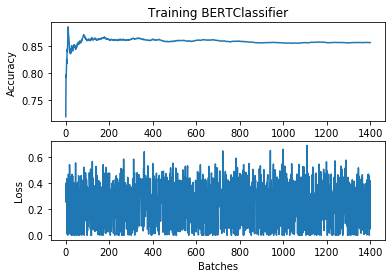

  0%|          | 0/600 [00:00<?, ?it/s]

Time for [4 - train model - 4]: 0:21:43.599057


100%|██████████| 600/600 [03:00<00:00,  3.32it/s]


Time for [prediction]: 0:03:00.545385
Accuracy in epoch 4: 0.8286995983516771
Confusion Matrix:
[[7723 1110]
 [2174 8164]]

Accuracy:  0.83 

Report for [BERTClassifier]:
              precision    recall  f1-score   support

           0       0.78      0.87      0.82      8833
           1       0.88      0.79      0.83     10338

    accuracy                           0.83     19171
   macro avg       0.83      0.83      0.83     19171
weighted avg       0.83      0.83      0.83     19171

Time for [6 - evaluate - 4]: 0:03:00.771421


In [22]:
for epoch_id in range(5):
    with Timer("4 - train model - {}".format(epoch_id)):
        stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=epoch_id + 1)
        plot_train_stats(stats)

    with Timer("6 - evaluate - {}".format(epoch_id)):
        all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
        print("Accuracy in epoch {}:".format(epoch_id), metric.get()[1])
        y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
        report_training_results(y_true, y_pred, name="BERTClassifier", heatmap=False)

    model.save_parameters("data/bert.model.params")

_may need to use **binary_cross_entrophy**?_ (can I use a single label or do I have to use "0" and "1"?)

### Cross topic - Training and evaluating model 

In [40]:
# 1. Getting train and dev data
with Timer("1 - test/train split"):
    X_train, X_dev, y_train, y_dev = get_train_test_sets(cross_traindev_df)

Time for [1 - test/train split]: 0:00:00.023909


In [41]:
# 2. setup
with Timer("2 - setup BERT model"):
    model, vocabulary, ctx, transform, loss_function, metric, all_labels = setup_bert()

BERTModel(
  (encoder): BERTEncoder(
    (dropout_layer): Dropout(p = 0.1, axes=())
    (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
    (transformer_cells): HybridSequential(
      (0): BERTEncoderCell(
        (dropout_layer): Dropout(p = 0.1, axes=())
        (attention_cell): MultiHeadAttentionCell(
          (_base_cell): DotProductAttentionCell(
            (_dropout_layer): Dropout(p = 0.1, axes=())
          )
          (proj_query): Dense(768 -> 768, linear)
          (proj_key): Dense(768 -> 768, linear)
          (proj_value): Dense(768 -> 768, linear)
        )
        (proj): Dense(768 -> 768, linear)
        (ffn): BERTPositionwiseFFN(
          (ffn_1): Dense(768 -> 3072, linear)
          (activation): GELU()
          (ffn_2): Dense(3072 -> 768, linear)
          (dropout_layer): Dropout(p = 0.1, axes=())
          (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
        )
        (la

In [44]:
with Timer("3 - prepare training data"):
    data_train_raw, data_train = transform_dataset(X_train, y_train, transform)
    print_infos(vocabulary, data_train_raw, data_train)

doctors that perform abortions are often emotionally damaged
unborn life should never depend on whether it is "wanted"
1
vocabulary used for tokenization = 
Vocab(size=30522, unk="[UNK]", reserved="['[PAD]', '[CLS]', '[SEP]', '[MASK]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = 
[    2  7435  2008  4685 11324  2015  2024  2411 14868  5591     3  4895
 10280  2166  2323  2196 12530  2006  3251  2009  2003  1000  2359  1000
     3     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     

In [ ]:
with Timer("4 - train model"):
    # train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=3)
    stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=2)
    # model.save_parameters("data/same-side-classification/cross-topic/bert.model.params")
    model.save_parameters("data/bert.model.params")

    plot_train_stats(stats)

In [45]:
with Timer("5 - prepare eval data"):
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    print_infos(vocabulary, data_dev_raw, data_dev)

alcoholism and drug-use are common after abortions.
uncertainty over whether fetuses are "life" should halt abortions.
1
vocabulary used for tokenization = 
Vocab(size=30522, unk="[UNK]", reserved="['[PAD]', '[CLS]', '[SEP]', '[MASK]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = 
[    2 25519  1998  4319  1011  2224  2024  2691  2044 11324  2015  1012
     3 12503  2058  3251 10768  5809  2229  2024  1000  2166  1000  2323
  9190 11324  2015  1012     3     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     

In [ ]:
with Timer("6 - evaluate"):
    # model.load_parameters("data/same-side-classification/cross-topic/bert.model.params", ctx=ctx)
    model.load_parameters("data/bert.model.params", ctx=ctx)
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name="BERTClassifier", heatmap=False)

100%|██████████| 42733/42733 [03:00<00:00, 236.79it/s]


Time for [setup training]: 0:03:00.488541
[Epoch 0 Batch 10/1340] loss=0.7025, lr=0.0000050, acc=0.484 - time 0:00:08.361428
[Epoch 0 Batch 20/1340] loss=0.7088, lr=0.0000050, acc=0.502 - time 0:00:07.863861
[Epoch 0 Batch 30/1340] loss=0.6888, lr=0.0000050, acc=0.511 - time 0:00:07.851966
[Epoch 0 Batch 40/1340] loss=0.7203, lr=0.0000050, acc=0.494 - time 0:00:07.391622
[Epoch 0 Batch 50/1340] loss=0.6932, lr=0.0000050, acc=0.492 - time 0:00:08.379786
[Epoch 0 Batch 60/1340] loss=0.7044, lr=0.0000050, acc=0.492 - time 0:00:08.265135
[Epoch 0 Batch 70/1340] loss=0.7040, lr=0.0000050, acc=0.495 - time 0:00:08.368734
[Epoch 0 Batch 80/1340] loss=0.7151, lr=0.0000050, acc=0.488 - time 0:00:07.782704
[Epoch 0 Batch 90/1340] loss=0.6918, lr=0.0000050, acc=0.492 - time 0:00:07.803205
[Epoch 0 Batch 100/1340] loss=0.6957, lr=0.0000050, acc=0.497 - time 0:00:08.127170
[Epoch 0 Batch 110/1340] loss=0.6970, lr=0.0000050, acc=0.498 - time 0:00:07.942732
[Epoch 0 Batch 120/1340] loss=0.7053, lr=0.

[Epoch 0 Batch 990/1340] loss=0.3575, lr=0.0000050, acc=0.643 - time 0:00:07.525804
[Epoch 0 Batch 1000/1340] loss=0.3347, lr=0.0000050, acc=0.645 - time 0:00:07.836028
[Epoch 0 Batch 1010/1340] loss=0.4355, lr=0.0000050, acc=0.646 - time 0:00:07.923276
[Epoch 0 Batch 1020/1340] loss=0.3516, lr=0.0000050, acc=0.648 - time 0:00:08.059239
[Epoch 0 Batch 1030/1340] loss=0.3880, lr=0.0000050, acc=0.649 - time 0:00:08.442039
[Epoch 0 Batch 1040/1340] loss=0.3875, lr=0.0000050, acc=0.650 - time 0:00:08.250785
[Epoch 0 Batch 1050/1340] loss=0.4257, lr=0.0000050, acc=0.652 - time 0:00:08.270033
[Epoch 0 Batch 1060/1340] loss=0.4278, lr=0.0000050, acc=0.652 - time 0:00:08.211137
[Epoch 0 Batch 1070/1340] loss=0.4119, lr=0.0000050, acc=0.653 - time 0:00:08.053046
[Epoch 0 Batch 1080/1340] loss=0.3934, lr=0.0000050, acc=0.654 - time 0:00:08.373578
[Epoch 0 Batch 1090/1340] loss=0.3717, lr=0.0000050, acc=0.656 - time 0:00:08.250543
[Epoch 0 Batch 1100/1340] loss=0.4026, lr=0.0000050, acc=0.657 - t

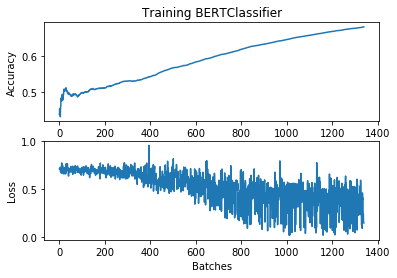

  0%|          | 0/573 [00:00<?, ?it/s]

Time for [4 - train model - 0]: 0:21:00.905422


100%|██████████| 573/573 [02:54<00:00,  4.12it/s]


Time for [prediction]: 0:02:54.762028
Accuracy in epoch 0: 0.7991263991263992
Confusion Matrix:
[[7070 1866]
 [1813 7566]]

Accuracy:  0.8 

Report for [BERTClassifier]:
              precision    recall  f1-score   support

           0       0.80      0.79      0.79      8936
           1       0.80      0.81      0.80      9379

    accuracy                           0.80     18315
   macro avg       0.80      0.80      0.80     18315
weighted avg       0.80      0.80      0.80     18315

Time for [6 - evaluate - 0]: 0:02:55.008217


100%|██████████| 42733/42733 [03:00<00:00, 237.31it/s]


Time for [setup training]: 0:03:00.088994
loaded checkpoint for epoch 0
[Epoch 1 Batch 10/1340] loss=0.3190, lr=0.0000050, acc=0.800 - time 0:00:08.056887
[Epoch 1 Batch 20/1340] loss=0.3110, lr=0.0000050, acc=0.802 - time 0:00:07.907804
[Epoch 1 Batch 30/1340] loss=0.3312, lr=0.0000050, acc=0.810 - time 0:00:08.123907
[Epoch 1 Batch 40/1340] loss=0.3251, lr=0.0000050, acc=0.807 - time 0:00:07.982688
[Epoch 1 Batch 50/1340] loss=0.3924, lr=0.0000050, acc=0.799 - time 0:00:08.426876
[Epoch 1 Batch 60/1340] loss=0.3925, lr=0.0000050, acc=0.794 - time 0:00:08.285148
[Epoch 1 Batch 70/1340] loss=0.3130, lr=0.0000050, acc=0.796 - time 0:00:07.978104
[Epoch 1 Batch 80/1340] loss=0.3142, lr=0.0000050, acc=0.800 - time 0:00:07.831400
[Epoch 1 Batch 90/1340] loss=0.2713, lr=0.0000050, acc=0.807 - time 0:00:07.877264
[Epoch 1 Batch 100/1340] loss=0.3511, lr=0.0000050, acc=0.806 - time 0:00:08.228175
[Epoch 1 Batch 110/1340] loss=0.3976, lr=0.0000050, acc=0.801 - time 0:00:08.138002
[Epoch 1 Batc

[Epoch 1 Batch 980/1340] loss=0.4607, lr=0.0000050, acc=0.820 - time 0:00:08.871616
[Epoch 1 Batch 990/1340] loss=0.3733, lr=0.0000050, acc=0.820 - time 0:00:08.322038
[Epoch 1 Batch 1000/1340] loss=0.3547, lr=0.0000050, acc=0.819 - time 0:00:08.491309
[Epoch 1 Batch 1010/1340] loss=0.2272, lr=0.0000050, acc=0.820 - time 0:00:07.748530
[Epoch 1 Batch 1020/1340] loss=0.3551, lr=0.0000050, acc=0.820 - time 0:00:08.271621
[Epoch 1 Batch 1030/1340] loss=0.3069, lr=0.0000050, acc=0.820 - time 0:00:07.956356
[Epoch 1 Batch 1040/1340] loss=0.2588, lr=0.0000050, acc=0.820 - time 0:00:07.735678
[Epoch 1 Batch 1050/1340] loss=0.1993, lr=0.0000050, acc=0.820 - time 0:00:07.585116
[Epoch 1 Batch 1060/1340] loss=0.2560, lr=0.0000050, acc=0.821 - time 0:00:07.761642
[Epoch 1 Batch 1070/1340] loss=0.4470, lr=0.0000050, acc=0.820 - time 0:00:08.552279
[Epoch 1 Batch 1080/1340] loss=0.2154, lr=0.0000050, acc=0.820 - time 0:00:07.786652
[Epoch 1 Batch 1090/1340] loss=0.3463, lr=0.0000050, acc=0.820 - ti

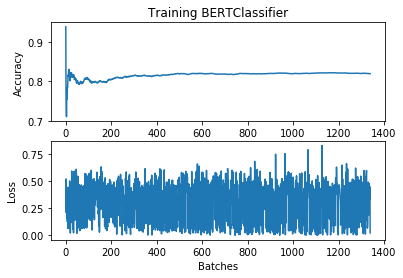

  0%|          | 0/573 [00:00<?, ?it/s]

Time for [4 - train model - 1]: 0:21:01.005022


100%|██████████| 573/573 [02:57<00:00,  3.23it/s]


Time for [prediction]: 0:02:57.432323
Accuracy in epoch 1: 0.8187278187278187
Confusion Matrix:
[[7652 1284]
 [2036 7343]]

Accuracy:  0.82 

Report for [BERTClassifier]:
              precision    recall  f1-score   support

           0       0.79      0.86      0.82      8936
           1       0.85      0.78      0.82      9379

    accuracy                           0.82     18315
   macro avg       0.82      0.82      0.82     18315
weighted avg       0.82      0.82      0.82     18315

Time for [6 - evaluate - 1]: 0:02:57.626244


100%|██████████| 42733/42733 [02:53<00:00, 246.88it/s]


Time for [setup training]: 0:02:53.112406
loaded checkpoint for epoch 0
loaded checkpoint for epoch 1
[Epoch 2 Batch 10/1340] loss=0.2412, lr=0.0000050, acc=0.859 - time 0:00:07.817955
[Epoch 2 Batch 20/1340] loss=0.2040, lr=0.0000050, acc=0.867 - time 0:00:07.625184
[Epoch 2 Batch 30/1340] loss=0.2719, lr=0.0000050, acc=0.865 - time 0:00:07.838813
[Epoch 2 Batch 40/1340] loss=0.3653, lr=0.0000050, acc=0.851 - time 0:00:08.649719
[Epoch 2 Batch 50/1340] loss=0.2842, lr=0.0000050, acc=0.849 - time 0:00:07.830874
[Epoch 2 Batch 60/1340] loss=0.3562, lr=0.0000050, acc=0.837 - time 0:00:08.358638
[Epoch 2 Batch 70/1340] loss=0.2436, lr=0.0000050, acc=0.841 - time 0:00:07.681605
[Epoch 2 Batch 80/1340] loss=0.3478, lr=0.0000050, acc=0.836 - time 0:00:08.520210
[Epoch 2 Batch 90/1340] loss=0.1898, lr=0.0000050, acc=0.843 - time 0:00:07.510132
[Epoch 2 Batch 100/1340] loss=0.3564, lr=0.0000050, acc=0.836 - time 0:00:08.627896
[Epoch 2 Batch 110/1340] loss=0.3529, lr=0.0000050, acc=0.833 - tim

[Epoch 2 Batch 980/1340] loss=0.2240, lr=0.0000050, acc=0.842 - time 0:00:08.165436
[Epoch 2 Batch 990/1340] loss=0.3044, lr=0.0000050, acc=0.842 - time 0:00:08.165068
[Epoch 2 Batch 1000/1340] loss=0.1561, lr=0.0000050, acc=0.843 - time 0:00:07.652056
[Epoch 2 Batch 1010/1340] loss=0.3104, lr=0.0000050, acc=0.843 - time 0:00:08.190643
[Epoch 2 Batch 1020/1340] loss=0.3481, lr=0.0000050, acc=0.842 - time 0:00:08.592282
[Epoch 2 Batch 1030/1340] loss=0.2892, lr=0.0000050, acc=0.842 - time 0:00:08.040040
[Epoch 2 Batch 1040/1340] loss=0.2194, lr=0.0000050, acc=0.842 - time 0:00:07.808520
[Epoch 2 Batch 1050/1340] loss=0.1971, lr=0.0000050, acc=0.843 - time 0:00:07.650845
[Epoch 2 Batch 1060/1340] loss=0.3691, lr=0.0000050, acc=0.842 - time 0:00:08.313384
[Epoch 2 Batch 1070/1340] loss=0.3135, lr=0.0000050, acc=0.842 - time 0:00:08.319475
[Epoch 2 Batch 1080/1340] loss=0.3479, lr=0.0000050, acc=0.842 - time 0:00:08.659965
[Epoch 2 Batch 1090/1340] loss=0.3405, lr=0.0000050, acc=0.841 - ti

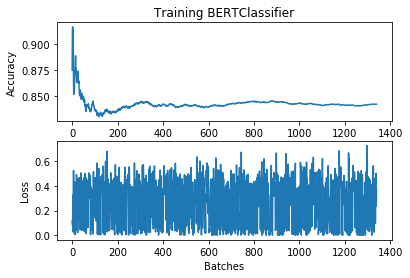

  0%|          | 0/573 [00:00<?, ?it/s]

Time for [4 - train model - 2]: 0:20:56.132282


100%|██████████| 573/573 [02:54<00:00,  3.29it/s]


Time for [prediction]: 0:02:54.209424
Accuracy in epoch 2: 0.8252798252798252
Confusion Matrix:
[[8008  928]
 [2272 7107]]

Accuracy:  0.83 

Report for [BERTClassifier]:
              precision    recall  f1-score   support

           0       0.78      0.90      0.83      8936
           1       0.88      0.76      0.82      9379

    accuracy                           0.83     18315
   macro avg       0.83      0.83      0.82     18315
weighted avg       0.83      0.83      0.82     18315

Time for [6 - evaluate - 2]: 0:02:54.406360


100%|██████████| 42733/42733 [02:55<00:00, 243.17it/s]


Time for [setup training]: 0:02:55.751295
loaded checkpoint for epoch 0
loaded checkpoint for epoch 1
loaded checkpoint for epoch 2
[Epoch 3 Batch 10/1340] loss=0.2473, lr=0.0000050, acc=0.884 - time 0:00:08.029340
[Epoch 3 Batch 20/1340] loss=0.2455, lr=0.0000050, acc=0.870 - time 0:00:07.872185
[Epoch 3 Batch 30/1340] loss=0.2390, lr=0.0000050, acc=0.872 - time 0:00:07.859373
[Epoch 3 Batch 40/1340] loss=0.2375, lr=0.0000050, acc=0.870 - time 0:00:07.893533
[Epoch 3 Batch 50/1340] loss=0.3373, lr=0.0000050, acc=0.861 - time 0:00:08.711087
[Epoch 3 Batch 60/1340] loss=0.0932, lr=0.0000050, acc=0.876 - time 0:00:07.244797
[Epoch 3 Batch 70/1340] loss=0.3387, lr=0.0000050, acc=0.867 - time 0:00:08.466650
[Epoch 3 Batch 80/1340] loss=0.3627, lr=0.0000050, acc=0.858 - time 0:00:08.566466
[Epoch 3 Batch 90/1340] loss=0.3102, lr=0.0000050, acc=0.853 - time 0:00:08.307661
[Epoch 3 Batch 100/1340] loss=0.2763, lr=0.0000050, acc=0.853 - time 0:00:08.054355
[Epoch 3 Batch 110/1340] loss=0.2948,

[Epoch 3 Batch 980/1340] loss=0.2894, lr=0.0000050, acc=0.869 - time 0:00:08.244752
[Epoch 3 Batch 990/1340] loss=0.3009, lr=0.0000050, acc=0.869 - time 0:00:08.227153
[Epoch 3 Batch 1000/1340] loss=0.2880, lr=0.0000050, acc=0.868 - time 0:00:08.239553
[Epoch 3 Batch 1010/1340] loss=0.2211, lr=0.0000050, acc=0.869 - time 0:00:08.125446
[Epoch 3 Batch 1020/1340] loss=0.2032, lr=0.0000050, acc=0.869 - time 0:00:07.937979
[Epoch 3 Batch 1030/1340] loss=0.3282, lr=0.0000050, acc=0.868 - time 0:00:08.073664
[Epoch 3 Batch 1040/1340] loss=0.2977, lr=0.0000050, acc=0.868 - time 0:00:08.296232
[Epoch 3 Batch 1050/1340] loss=0.3021, lr=0.0000050, acc=0.868 - time 0:00:08.249256
[Epoch 3 Batch 1060/1340] loss=0.2971, lr=0.0000050, acc=0.868 - time 0:00:08.405073
[Epoch 3 Batch 1070/1340] loss=0.1828, lr=0.0000050, acc=0.868 - time 0:00:07.701351
[Epoch 3 Batch 1080/1340] loss=0.2723, lr=0.0000050, acc=0.868 - time 0:00:08.210484
[Epoch 3 Batch 1090/1340] loss=0.1998, lr=0.0000050, acc=0.868 - ti

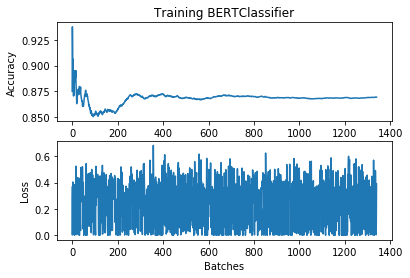

  0%|          | 0/573 [00:00<?, ?it/s]

Time for [4 - train model - 3]: 0:20:56.171990


100%|██████████| 573/573 [02:48<00:00,  3.41it/s]


Time for [prediction]: 0:02:48.229060
Accuracy in epoch 3: 0.8398034398034399
Confusion Matrix:
[[7905 1031]
 [1903 7476]]

Accuracy:  0.84 

Report for [BERTClassifier]:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      8936
           1       0.88      0.80      0.84      9379

    accuracy                           0.84     18315
   macro avg       0.84      0.84      0.84     18315
weighted avg       0.84      0.84      0.84     18315

Time for [6 - evaluate - 3]: 0:02:48.447808


100%|██████████| 42733/42733 [02:53<00:00, 246.99it/s]


Time for [setup training]: 0:02:53.033514
loaded checkpoint for epoch 0
loaded checkpoint for epoch 1
loaded checkpoint for epoch 2
loaded checkpoint for epoch 3
[Epoch 4 Batch 10/1340] loss=0.2879, lr=0.0000050, acc=0.856 - time 0:00:08.819047
[Epoch 4 Batch 20/1340] loss=0.3237, lr=0.0000050, acc=0.838 - time 0:00:08.510386
[Epoch 4 Batch 30/1340] loss=0.1372, lr=0.0000050, acc=0.869 - time 0:00:07.445968
[Epoch 4 Batch 40/1340] loss=0.1921, lr=0.0000050, acc=0.879 - time 0:00:08.055229
[Epoch 4 Batch 50/1340] loss=0.1141, lr=0.0000050, acc=0.894 - time 0:00:07.778778
[Epoch 4 Batch 60/1340] loss=0.2939, lr=0.0000050, acc=0.887 - time 0:00:07.995121
[Epoch 4 Batch 70/1340] loss=0.2473, lr=0.0000050, acc=0.885 - time 0:00:07.895962
[Epoch 4 Batch 80/1340] loss=0.1911, lr=0.0000050, acc=0.886 - time 0:00:07.983766
[Epoch 4 Batch 90/1340] loss=0.2203, lr=0.0000050, acc=0.887 - time 0:00:08.456483
[Epoch 4 Batch 100/1340] loss=0.2791, lr=0.0000050, acc=0.885 - time 0:00:08.371531
[Epoch 

[Epoch 4 Batch 970/1340] loss=0.2269, lr=0.0000050, acc=0.892 - time 0:00:08.059267
[Epoch 4 Batch 980/1340] loss=0.2893, lr=0.0000050, acc=0.891 - time 0:00:08.431667
[Epoch 4 Batch 990/1340] loss=0.0970, lr=0.0000050, acc=0.892 - time 0:00:07.226958
[Epoch 4 Batch 1000/1340] loss=0.1872, lr=0.0000050, acc=0.892 - time 0:00:07.658970
[Epoch 4 Batch 1010/1340] loss=0.1682, lr=0.0000050, acc=0.892 - time 0:00:08.107551
[Epoch 4 Batch 1020/1340] loss=0.2266, lr=0.0000050, acc=0.893 - time 0:00:07.991096
[Epoch 4 Batch 1030/1340] loss=0.1403, lr=0.0000050, acc=0.893 - time 0:00:07.313752
[Epoch 4 Batch 1040/1340] loss=0.1839, lr=0.0000050, acc=0.893 - time 0:00:07.977764
[Epoch 4 Batch 1050/1340] loss=0.1698, lr=0.0000050, acc=0.893 - time 0:00:07.706508
[Epoch 4 Batch 1060/1340] loss=0.2510, lr=0.0000050, acc=0.893 - time 0:00:07.642596
[Epoch 4 Batch 1070/1340] loss=0.2044, lr=0.0000050, acc=0.893 - time 0:00:08.102700
[Epoch 4 Batch 1080/1340] loss=0.2161, lr=0.0000050, acc=0.893 - tim

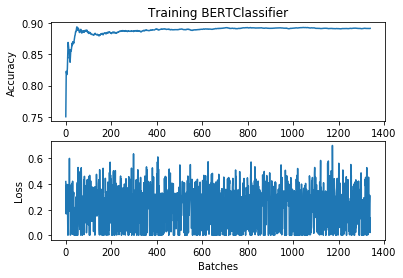

  0%|          | 0/573 [00:00<?, ?it/s]

Time for [4 - train model - 4]: 0:20:54.438874


100%|██████████| 573/573 [02:50<00:00,  3.36it/s]


Time for [prediction]: 0:02:50.732861
Accuracy in epoch 4: 0.8485940485940486
Confusion Matrix:
[[7708 1228]
 [1545 7834]]

Accuracy:  0.85 

Report for [BERTClassifier]:
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      8936
           1       0.86      0.84      0.85      9379

    accuracy                           0.85     18315
   macro avg       0.85      0.85      0.85     18315
weighted avg       0.85      0.85      0.85     18315

Time for [6 - evaluate - 4]: 0:02:50.930598


In [46]:
for epoch_id in range(5):
    with Timer("4 - train model - {}".format(epoch_id)):
        stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=epoch_id + 1)
        plot_train_stats(stats)

    with Timer("6 - evaluate - {}".format(epoch_id)):
        all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
        print("Accuracy in epoch {}:".format(epoch_id), metric.get()[1])
        y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
        report_training_results(y_true, y_pred, name="BERTClassifier", heatmap=False)

    model.save_parameters("data/bert.model.params")